# Projekt - Inżynieria lingwistyczna

### PolEval 2019 - Task 6: Automatic cyberbullying detection
Link: http://2019.poleval.pl/index.php/tasks/task6

## Opis zadania:

Zadanie to podzielone jest na 2 podpunkty - Zadanie 6.1 oraz Zadanie 6.2

### Zadanie 6.1: Harmful vs. non-harmful tweets

In this task, the participants are to distinguish between:

- **normal/non-harmful tweets** (class: 0)
- **harmful information** (class: 1)

This includes cyberbullying, hate speech and related phenomena. The data for the task is available now and can be downloaded from the link provided below.

Task 6-1 training data: http://2019.poleval.pl/task6/task_6-1.zip

### Zadanie 6.2: Type of harmfulness

In this task, the participants shall distinguish between three classes of tweets: 
- 0 **(non-harmful)** 
- 1 **(cyberbullying)**
- 2 **(hate-speech)**

There are various definitions of both cyberbullying and hate-speech, some of them even putting those two phenomena in the same group. The specific conditions on which we based our annotations for both cyberbullying and hate-speech, which have been worked out during ten years of research will be summarized in an introductory paper for the task, however, the main and definitive condition to distinguish the two is whether the harmful action is addressed towards a private person(s) (cyberbullying), or a public person/entity/large group (hate-speech).

Task 6-2 training data: http://2019.poleval.pl/task6/task_6-2.zip

Test data: http://2019.poleval.pl/task6/task6_test.zip

---

- Dane podzielone są na dwa pliki: train i test. Podczas trenowania modelu plik train dzielimy na dwie części - część treningową i część walidacyjną. Następnie wytrenowany model sprawdzamy na zbiorze testowym.
- Wyniki tego konkursu można znaleźć tutaj: http://2019.poleval.pl/files/2019/13.pdf

## TOC

[1. Data preparing](#1.-Data-preparing) <br />
&emsp;&emsp; [1.1. Libraries importing](#1.1.-Libraries-importing) <br />
&emsp;&emsp; [1.2. Data loading](#1.2.-Data-loading) <br />
&emsp;&emsp; [1.3. Data cleaning](#1.3.-Data-cleaning) <br />

[2. Visualization](#2.-Visualization) <br />
&emsp;&emsp; [2.1. Stosunek harmful / non-harmful tweets](#2.1.-Stosunek-harmful-/-non-harmful-tweets) <br />
&emsp;&emsp; [2.2. Most common words](#2.2.-Most-common-words) <br />

[Zadanie 6.1](#Zadanie-6.1) <br />
[Zadanie 6.2](#Zadanie-6.2) <br />



### 1. Data preparing

Zbiór tweetów jest w obu zadaniach identyczny, różnią się jedynie etykiety - w `zadaniu 6.1` jest tylko 0 i 1, w `zadaniu 6.2` jest 0, 1 i 2


#### 1.1. Libraries importing

In [5]:
# !pip install -q emoji
# !pip install -q wordcloud
# !python -m spacy download pl_core_news_lg
# !python -m spacy download en_core_web_lg

In [6]:
import spacy
import re
import numpy as np
import emoji
from collections import Counter
from wordcloud import WordCloud
import pl_core_news_lg
import pandas as pd
pd.options.mode.chained_assignment = None
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import *
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.utils import shuffle
from sklearn.preprocessing import LabelEncoder

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, SpatialDropout1D, Bidirectional, Dropout, Flatten
from sklearn.feature_extraction.text import TfidfTransformer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.losses import BinaryCrossentropy
from keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical

#### 1.2. Data loading

In [7]:
#Task 6.1
task61_train_text = pd.read_csv('data/task_6.1/train/training_set_clean_only_text.txt', names=['text'], sep='\t')
task61_train_label = pd.read_csv('data/task_6.1/train/training_set_clean_only_tags.txt', names=['label'], sep='\t')
df1 = pd.concat([task61_train_text, task61_train_label], axis=1)

task61_test_text = pd.read_csv('data/task_6.1/test/test_set_clean_only_text.txt', names=['text'], sep='\t')
task61_test_label = pd.read_csv('data/task_6.1/test/test_set_clean_only_tags.txt', names=['label'], sep='\t')
df1_test = pd.concat([task61_test_text, task61_test_label], axis=1)

# Task 6.2
task62_train_text = pd.read_csv('data/task_6.2/train/training_set_clean_only_text.txt', names=['text'], sep='\t')
task62_train_label = pd.read_csv('data/task_6.2/train/training_set_clean_only_tags.txt', names=['label'], sep='\t')
df2 = pd.concat([task62_train_text, task62_train_label], axis=1)

task62_train_text = pd.read_csv('data/task_6.2/test/test_set_only_text.txt', names=['text'], sep='\t')
task62_train_label = pd.read_csv('data/task_6.2/test/test_set_only_tags.txt', names=['label'], sep='\t')
df2_test = pd.concat([task62_train_text, task62_train_label], axis=1)

df1.head()

,text,label
0,Dla mnie faworytem do tytułu będzie Cracovia. ...,0
1,@anonymized_account @anonymized_account Brawo ...,0
2,"@anonymized_account @anonymized_account Super,...",0
3,@anonymized_account @anonymized_account Musi. ...,0
4,"Odrzut natychmiastowy, kwaśna mina, mam problem",0


#### 1.3. Data cleaning

- .lower()
- usunięcie: 
    - @anonymized_account, 
    - linków, 
    - znaków typu ,?: 
- `stop words`
- `lematyzacja`

In [8]:
nlp = pl_core_news_lg.load()
stop_words = nlp.Defaults.stop_words # 381 stop words
stop_words.add('mieć')

def clean_text(tweet):
    tweet = tweet.lower() # zamiana na lowercase
    tweet = ' '.join([word for word in tweet.split() if word not in stop_words])
    tweet = ' '.join([word for word in tweet.split() if not word.isdigit()])
    tweet = re.sub('((http|https)\:\/\/)?[a-zA-Z0-9\.\/\?\:@\-_=#]+\.([a-zA-Z]){2,6}([a-zA-Z0-9\.\&\/\?\:@\-_=#])*', "", tweet) # usuwamy linki
    tweet = tweet.replace("@anonymized_account", '') # nazwy użytkowników zostały zastąpione przez @anonymized_account
    tweet = tweet.replace("...", '')
    tweet = tweet.replace("rt", '') # usuwamy słowo rt występujące na początku niektórych tweetów
    tweet = tweet.replace("\\n", ' ') # usuwamy znaki nowej linii
    tweet = tweet.replace('\"', '') # usuwamy znaki cudzysłowu
    tweet = tweet.replace("\'", '')
    tweet = tweet.replace("/", '')
    tweet = tweet.replace("\\", '')
    tweet = tweet.replace('”', '')
    tweet = tweet.replace('?', ' ')
    tweet = tweet.replace(')', ' ')
    tweet = tweet.replace('(', ' ')
    tweet = tweet.replace('!', ' ')
    tweet = tweet.replace('#', ' ')
    tweet = tweet.replace(':', ' ')
    tweet = tweet.replace(';', ' ')
    tweet = tweet.replace('-', ' ')
    tweet = tweet.replace('.', ' ')
    tweet = tweet.replace(',', ' ')
    tweet = tweet.replace('$', ' ')
    tweet = emoji.replace_emoji(tweet, "") # usuwamy emoji
    tweet = tweet.strip() # usuwamy nadmiarowe białe znaki z początku i końcu
    return tweet

def preprocess_data(df):
    df = df.drop_duplicates(subset=['text'], keep='first') # łącznie 17 wierszy jest duplikatami
    df['text_lemmatized_in_tokens'] = df['text'].apply(lambda x: [token.lemma_ for token in nlp(str(x))])
    df['text_lemmatized'] = df['text'].apply(lambda x: " ".join([token.lemma_ for token in nlp(str(x))]))
    df['cleaned_text'] = df['text_lemmatized'].apply(clean_text) 
    df['sentiment'] = df['label'].apply(lambda x: 'neutral' if x == 0 else 'harmful')
    df = df[['text', 'text_lemmatized_in_tokens', 'text_lemmatized', 'cleaned_text', 'label', 'sentiment']]
    return df

# df1 = preprocess_data(df1)
# df1_test = preprocess_data(df1_test)
# df2 = preprocess_data(df2)
# df2_test = preprocess_data(df2_test)

# df1.to_csv('df1_cleaned_preprocessed.csv', index=False)
# df1_test.to_csv('df1_test_cleaned_preprocessed.csv', index=False)
# df2.to_csv('df2_cleaned_preprocessed.csv', index=False)
# df2_test.to_csv('df2_test_cleaned_preprocessed.csv', index=False)

# df1.head()

In [9]:
df1 = pd.read_csv('df1_cleaned_preprocessed.csv')
df1_test = pd.read_csv('df1_test_cleaned_preprocessed.csv')
df2 = pd.read_csv('df2_cleaned_preprocessed.csv')
df2_test = pd.read_csv('df2_test_cleaned_preprocessed.csv')

df1 = df1.dropna(subset=['cleaned_text'])
df1_test = df1_test.dropna(subset=['cleaned_text'])
df2 = df2.dropna(subset=['cleaned_text'])
df2_test = df2_test.dropna(subset=['cleaned_text'])

df1.head()

,text,text_lemmatized_in_tokens,text_lemmatized,cleaned_text,label,sentiment
0,Dla mnie faworytem do tytułu będzie Cracovia. ...,"['dla', 'ja', 'faworyt', 'do', 'tytuł', 'być',...",dla ja faworyt do tytuł być Cracovia . zobaczy...,faworyt tytuł cracovia zobaczyć typ sprawdzić,0,neutral
1,@anonymized_account @anonymized_account Brawo ...,"['@anonymized_account', '@anonymized_account',...",@anonymized_account @anonymized_account brawo ...,brawo daria kibic dobry zły,0,neutral
2,"@anonymized_account @anonymized_account Super,...","['@anonymized_account', '@anonymized_account',...",@anonymized_account @anonymized_account Super ...,super polski premier składać kwiat grobach k...,0,neutral
3,@anonymized_account @anonymized_account Musi. ...,"['@anonymized_account', '@anonymized_account',...",@anonymized_account @anonymized_account musi ....,droga,0,neutral
4,"Odrzut natychmiastowy, kwaśna mina, mam problem","['odrzut', 'natychmiastowy', ',', 'kwaśny', 'm...","odrzut natychmiastowy , kwaśny mina , mieć pro...",odrzut natychmiastowy kwaśny mina problem,0,neutral


### 2. Visualization
#### 2.1. Stosunek harmful / non-harmful tweets


In [10]:
stats = df1['label'].map({0:'Non-harmful', 1:'Harmful'})
stats.groupby(stats).count()

label
Harmful         849
Non-harmful    9147
Name: label, dtype: int64

In [11]:
list(df1[df1['label'] == 0]['cleaned_text'].head(10))

['faworyt tytuł cracovia   zobaczyć   typ sprawdzić',
 'brawo daria kibic dobry zły',
 'super   polski premier składać kwiat grobach kolaborant   doczekać czas',
 'droga',
 'odrzut natychmiastowy   kwaśny mina   problem',
 'fajny xdd pamiętać   spóźnić pierwszy zajęcie sporo kara kazać usiąść pierwszy ławka xd',
 'szczęście',
 'dawno wredny widzieć xd',
 'zaległość   ważny wezwanie zapłata klub wywiązać',
 'nadzieja']

In [12]:
list(df1[df1['label'] == 1]['cleaned_text'].head(10))

['brudziński kłamca marny kutas',
 'skończmy kurwa wersal j  ej szczujny',
 'woronicz poseł halicki oburzyć bolk   naprawdè tępy udawać idiota',
 'naraa przywidzenie zmieniać fakt czas idiota',
 'nikt rozsiewać smród',
 'hehe   gaz   hehe emotikon wrzuć',
 'sekt   cha   cha   cha   obudź hipnoza   bolszewik',
 'jasny   debil oglądać tvpis płaczyć metr miłość',
 'zdrada stan donald tusk dopuścić rok dodać rosjan śledztwo sprawa katastrofa smoleński',
 'oszuście kłamco odpierdol   siebie dama rada kłamstwo']

<AxesSubplot: title={'center': 'Liczba elementów w zbiorze treningowym z podziałem na sentyment'}>

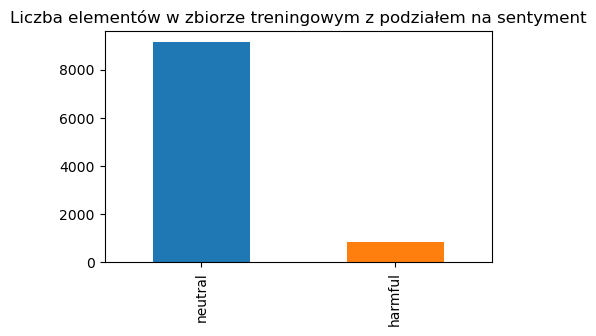

In [13]:
figzie = plt.figure(figsize=(5, 3))
df1['sentiment'].value_counts().plot(kind='bar', title='Liczba elementów w zbiorze treningowym z podziałem na sentyment', color=['#1f77b4', '#ff7f0e'])


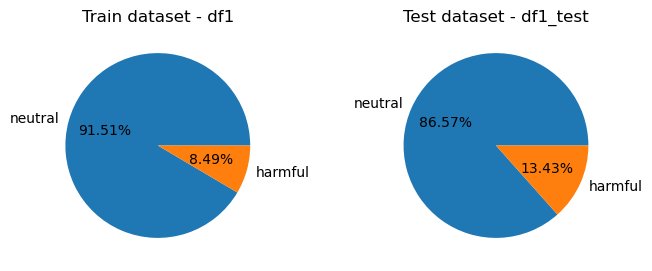

In [14]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 3))
ax1.pie(df1['sentiment'].value_counts(), labels = df1['sentiment'].unique(), autopct='%1.2f%%')
ax1.set_title('Train dataset - df1')
ax2.pie(df1_test['sentiment'].value_counts(), labels = df1_test['sentiment'].unique(), autopct='%1.2f%%')
ax2.set_title('Test dataset - df1_test')
plt.show()

#### 2.2. Most common words


Most common words - train set [non-harmful]:


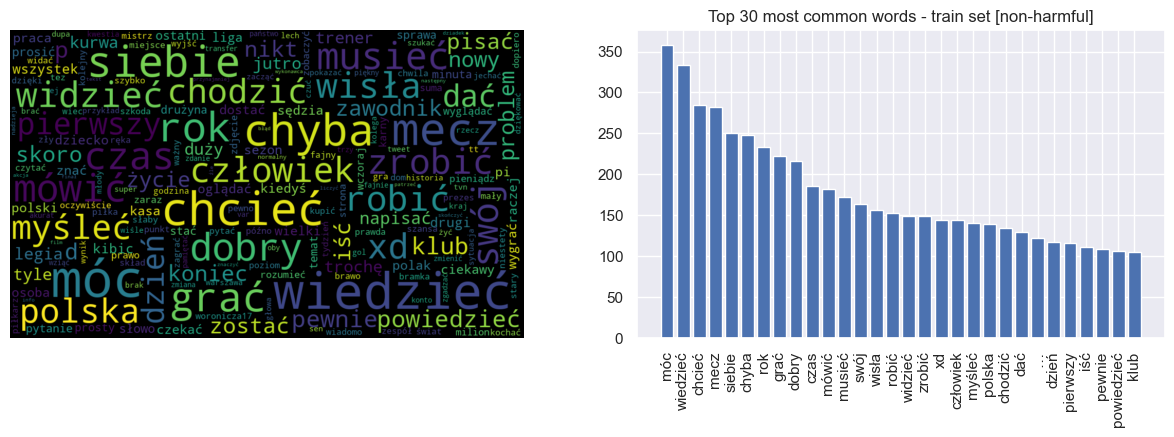

Most common words - train set [harmful]:


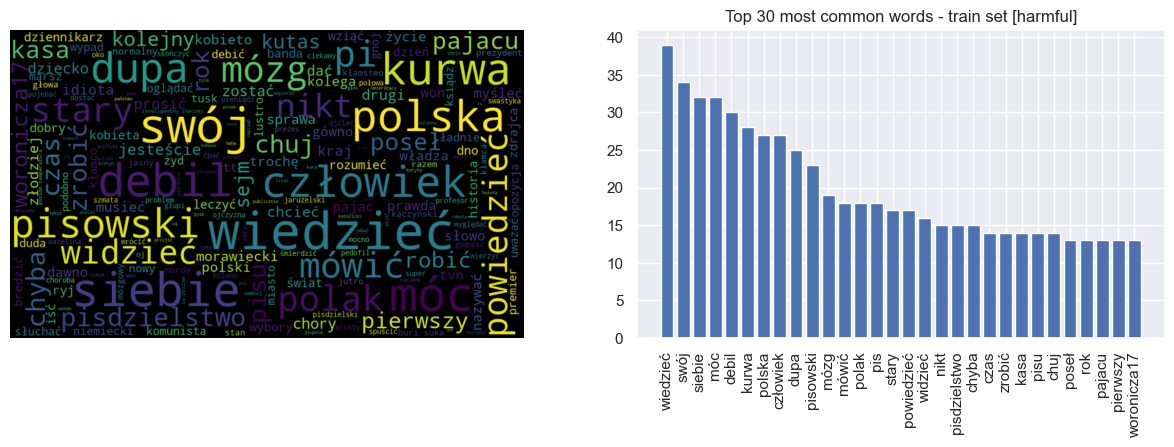

In [15]:
def get_most_common(all_words, top=20):
    most_common = Counter((all_words).split()).most_common(top)
    labels,values = [], []
    
    for label, value in most_common:
        labels.append(label)
        values.append(value)
        
    return values, labels


def plot_most_common(all_words, top=20, title=''):
    values, labels = get_most_common(all_words, top)
    wordcloud = WordCloud(width=1000, height=600, random_state=21, max_font_size=100).generate(all_words)
    x = range(len(values))
    sns.set_theme()

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 4))
    ax1.imshow(wordcloud, interpolation="bilinear")
    ax1.axis('off')

    ax2.bar(x, values)
    ax2.set_xticks(x, labels, rotation=90)
    ax2.set_title(title)
    plt.show()
    


all_words = ' '.join([str(text) for text in df1['cleaned_text']])
all_words1 = ' '.join([str(text) for text in df1['cleaned_text'][df1['label']==1]])
all_words0 = ' '.join([str(text) for text in df1['cleaned_text'][df1['label']==0]])

print('Most common words - train set [non-harmful]:')
plot_most_common(all_words0, top=30, title='Top 30 most common words - train set [non-harmful]')

print('Most common words - train set [harmful]:')
plot_most_common(all_words1, top=30, title='Top 30 most common words - train set [harmful]')

# Zadanie 6.1

In [16]:
es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=15, restore_best_weights=True)

def plot_history_charts(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 3))
    ax1.plot(history.history['accuracy'])
    ax1.plot(history.history['val_accuracy'])
    ax1.set_title('model accuracy')
    ax1.set(xlabel='epoch', ylabel='accuracy')
    ax1.legend(['train', 'test'], loc='upper left')

    ax2.plot(history.history['loss'])
    ax2.plot(history.history['val_loss'])
    ax2.set_title('model loss')
    ax2.set(xlabel='epoch', ylabel='loss')
    ax2.legend(['train', 'test'], loc='upper left')
    plt.show()


def evaluate_model_binary(model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_pred = np.where(y_pred > 0.5, 1, 0)
    print(classification_report(y_test, y_pred))
    
    print('Precision: {:.2f}%'.format(100*precision_score(y_test, y_pred)))
    print('Recall: {:.2f}%'.format(100*recall_score(y_test, y_pred)))
    print('F1 score: {:.2f}%'.format(100*f1_score(y_test, y_pred)))
    print('Accuracy: {:.2f}%'.format(100*accuracy_score(y_test, y_pred)))

    plt.figure(figsize=(4,3))
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d')
    plt.xlabel("Predicted label")
    plt.ylabel("True label")


def evaluate_model(model, X_test, y_test):
    y_pred = np.argmax(model.predict(X_test), axis=1)
    print(classification_report(y_test, y_pred))

    plt.figure(figsize=(4,3))
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d')
    plt.xlabel("Predicted label")
    plt.ylabel("True label")

## Regresja

              precision    recall  f1-score   support

           0       0.89      0.88      0.88       864
           1       0.26      0.28      0.27       134

    accuracy                           0.80       998
   macro avg       0.57      0.58      0.58       998
weighted avg       0.80      0.80      0.80       998

Precision: 26.03%
Recall: 28.36%
F1 score: 27.14%
Accuracy: 79.56%
None


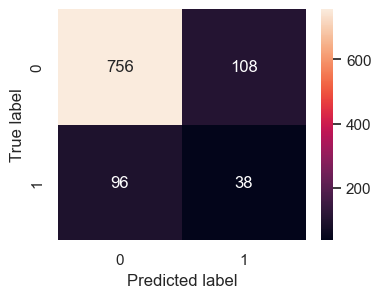

In [47]:
pipeline = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', (LinearRegression()))
])

train_X, train_y = df1['cleaned_text'], df1['label']
test_X, test_y = df1_test['cleaned_text'], df1_test['label']

train_X, train_y = shuffle(train_X, train_y, random_state=42)
pipeline.fit(train_X, train_y)
print(evaluate_model_binary(pipeline, test_X, test_y))

## Drzewo decyzyjne

              precision    recall  f1-score   support

           0       0.90      0.96      0.93       864
           1       0.55      0.31      0.39       134

    accuracy                           0.87       998
   macro avg       0.72      0.63      0.66       998
weighted avg       0.85      0.87      0.86       998

Precision: 54.67%
Recall: 30.60%
F1 score: 39.23%
Accuracy: 87.27%
None


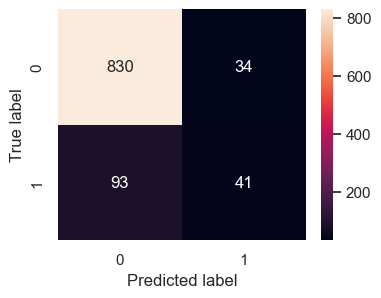

In [58]:
pipeline = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('tree', DecisionTreeClassifier(random_state=42))
])

train_X, train_y = df1['cleaned_text'], df1['label']
test_X, test_y = df1_test['cleaned_text'], df1_test['label']

train_X, train_y = shuffle(train_X, train_y, random_state=42)
pipeline.fit(train_X, train_y)
print(evaluate_model_binary(pipeline, test_X, test_y))

## Linear Support Vector Classification

              precision    recall  f1-score   support

           0       0.91      0.94      0.93       864
           1       0.51      0.43      0.47       134

    accuracy                           0.87       998
   macro avg       0.71      0.68      0.70       998
weighted avg       0.86      0.87      0.86       998

Precision: 51.33%
Recall: 43.28%
F1 score: 46.96%
Accuracy: 86.87%
None


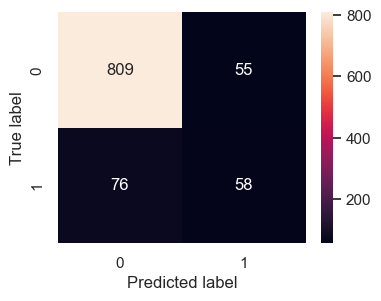

In [49]:
pipeline = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', LinearSVC(class_weight='balanced', random_state=42, max_iter=10000, C=0.15))
])

train_X, train_y = df1['cleaned_text'], df1['label']
test_X, test_y = df1_test['cleaned_text'], df1_test['label']

train_X, train_y = shuffle(train_X, train_y, random_state=42)
pipeline.fit(train_X, train_y)
print(evaluate_model_binary(pipeline, test_X, test_y))

<img src="task61results.png" width="600"/>

## Prosta sieć neuronowa

In [92]:
max_features = 1000
embed_dim = 128

tokenizer = Tokenizer(num_words=max_features, split=' ')
tokenizer.fit_on_texts(df1["cleaned_text"].values)
tweet_tokenized = tokenizer.texts_to_sequences(df1["cleaned_text"].values)
tweet_tokenized = pad_sequences(tweet_tokenized, maxlen=20)

tweet_tokenized = pd.DataFrame(tweet_tokenized)
y_train = df1['label']
X_train, X_val, y_train, y_val = train_test_split(tweet_tokenized, y_train, test_size=0.2, random_state=42, stratify=y_train)

X_test = tokenizer.texts_to_sequences(df1_test["cleaned_text"].values)
X_test = pad_sequences(X_test, maxlen=20)
y_test = df1_test['label']

Epoch 1/40
250/250 [==============================] - 2s 7ms/step - loss: 0.2918 - accuracy: 0.9126 - val_loss: 0.2546 - val_accuracy: 0.9150
Epoch 2/40
250/250 [==============================] - 2s 7ms/step - loss: 0.2080 - accuracy: 0.9201 - val_loss: 0.2775 - val_accuracy: 0.9095
Epoch 3/40
250/250 [==============================] - 2s 7ms/step - loss: 0.1611 - accuracy: 0.9388 - val_loss: 0.2867 - val_accuracy: 0.9130
Epoch 4/40
250/250 [==============================] - 2s 7ms/step - loss: 0.1295 - accuracy: 0.9505 - val_loss: 0.3559 - val_accuracy: 0.9060
Epoch 5/40
250/250 [==============================] - 2s 7ms/step - loss: 0.1164 - accuracy: 0.9561 - val_loss: 0.3815 - val_accuracy: 0.8980
Epoch 6/40
250/250 [==============================] - 2s 7ms/step - loss: 0.0998 - accuracy: 0.9596 - val_loss: 0.5492 - val_accuracy: 0.9025
Epoch 7/40
250/250 [==============================] - 2s 7ms/step - loss: 0.0917 - accuracy: 0.9624 - val_loss: 0.7979 - val_accuracy: 0.8925
Epoch 

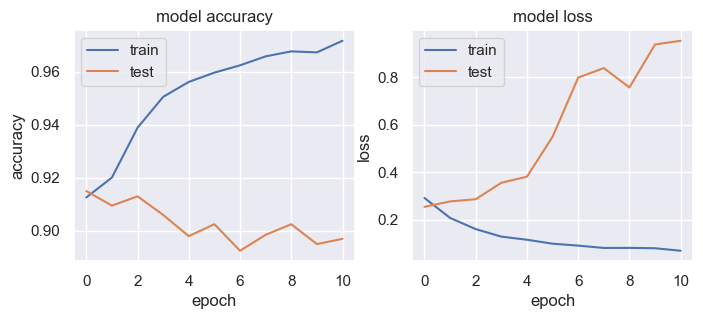

32/32 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

           0       0.87      0.97      0.92       864
           1       0.33      0.10      0.16       134

    accuracy                           0.85       998
   macro avg       0.60      0.54      0.54       998
weighted avg       0.80      0.85      0.82       998

Precision: 32.56%
Recall: 10.45%
F1 score: 15.82%
Accuracy: 85.07%
None


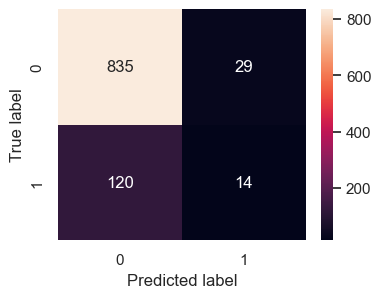

In [96]:
model = Sequential([
    Embedding(max_features, embed_dim, input_length=tweet_tokenized.shape[1]),
    Flatten(),
    Dense(1024, activation='relu'),
    Dense(512, activation='relu'),
    Dense(128, activation='relu'),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer='adam',metrics = ['accuracy'])
history = model.fit(X_train, y_train, batch_size=32, epochs=40, validation_data=(X_val, y_val), callbacks=[EarlyStopping(monitor='val_loss', patience=10)])
model.save('Task61_NN.h5')

plot_history_charts(history)
print(evaluate_model_binary(model, X_test, y_test))

## Bidirectional LSTM

Epoch 1/40
235/235 [==============================] - 6s 18ms/step - loss: 0.3031 - accuracy: 0.9110 - val_loss: 0.2591 - val_accuracy: 0.9152
Epoch 2/40
235/235 [==============================] - 3s 14ms/step - loss: 0.2257 - accuracy: 0.9190 - val_loss: 0.2716 - val_accuracy: 0.9004
Epoch 3/40
235/235 [==============================] - 3s 14ms/step - loss: 0.1977 - accuracy: 0.9270 - val_loss: 0.2684 - val_accuracy: 0.9108
Epoch 4/40
235/235 [==============================] - 3s 14ms/step - loss: 0.1758 - accuracy: 0.9344 - val_loss: 0.2853 - val_accuracy: 0.9084
Epoch 5/40
235/235 [==============================] - 3s 14ms/step - loss: 0.1553 - accuracy: 0.9418 - val_loss: 0.3060 - val_accuracy: 0.9100
Epoch 6/40
235/235 [==============================] - 3s 14ms/step - loss: 0.1411 - accuracy: 0.9458 - val_loss: 0.3260 - val_accuracy: 0.9060
Epoch 7/40
235/235 [==============================] - 3s 14ms/step - loss: 0.1299 - accuracy: 0.9504 - val_loss: 0.3734 - val_accuracy: 0.9032

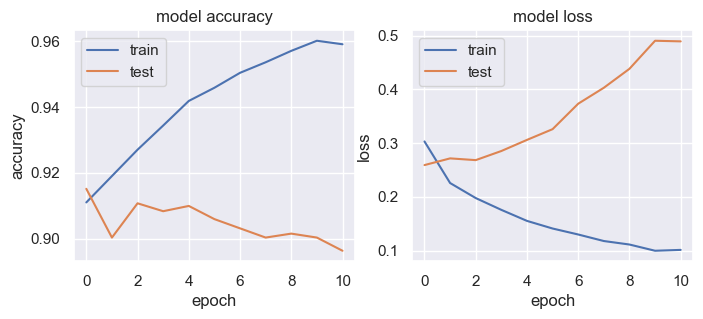

32/32 [==============================] - 1s 3ms/step
              precision    recall  f1-score   support

           0       0.88      0.96      0.92       864
           1       0.37      0.16      0.23       134

    accuracy                           0.85       998
   macro avg       0.62      0.56      0.57       998
weighted avg       0.81      0.85      0.82       998

Precision: 36.67%
Recall: 16.42%
F1 score: 22.68%
Accuracy: 84.97%
None


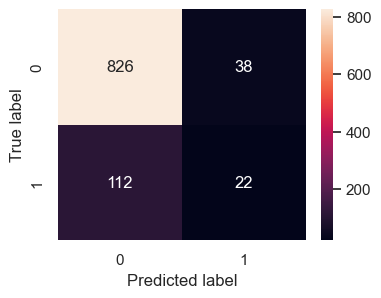

In [98]:
max_features = 1000
embed_dim = 128
lstm_out = 48

tokenizer = Tokenizer(num_words=max_features, split=' ')
tokenizer.fit_on_texts(df1["cleaned_text"].values)
tweet_tokenized = tokenizer.texts_to_sequences(df1["cleaned_text"].values)
tweet_tokenized = pad_sequences(tweet_tokenized, maxlen=20)
tweet_tokenized.shape

tweet_tokenized = pd.DataFrame(tweet_tokenized)
y_train = df1['label']
X_train, X_val, y_train, y_val = train_test_split(tweet_tokenized, y_train, test_size=0.25, random_state=42, stratify=y_train)

X_test = tokenizer.texts_to_sequences(df1_test["cleaned_text"].values)
X_test = pad_sequences(X_test, maxlen=20)
y_test = df1_test['label']

model = Sequential([
    Embedding(max_features, embed_dim, input_length=tweet_tokenized.shape[1]),
    Bidirectional(LSTM(lstm_out, return_sequences=True)),
    Bidirectional(LSTM(lstm_out)),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer='adam',metrics = ['accuracy'])
history = model.fit(X_train, y_train, batch_size=32, epochs=40, validation_data=(X_val, y_val), callbacks=[EarlyStopping(monitor='val_loss', patience=10)])
model.save('Task61_bidirectional_LSTM.h5')

plot_history_charts(history)
print(evaluate_model_binary(model, X_test, y_test))

# Wnioski:

- Najlepszy z naszych modeli (LinearSVC) uplasowałby nas w tym zadaniu na 10 miejscu, tuż za osobą z AGH i przed zespołem z IPI PAN

Sieci neuronowe poradziły sobie z tym zadaniem bardzo słabo. Obie miały problem z klasyfikacją tweetów, które są obraźliwe.
Główne przyczyny:
- bardzo mały zbiór danych - jedynie 10 000 tweetów
- nierówny zbiór danych - bardzo dużo tweetów, które nie są obraźliwe, a mało tweetów, które są obraźliwe
- niskiej jakości dane - po oczyszczeniu ich z linków, znaków interpunkcyjnych, stop words i lematyzacji pozostały bardzo małe ilości słów, które nie są wystarczające do klasyfikacji tweetów na wysokim poziomie

Przykładowo tweet: 

`brawo daria kibic mieć dobry zły`

 ciężko byłoby nawet ręcznie przydzielić do odpowiedniej klasy, podczas gdy wyjściowa wersja: 
 
 `Brawo ty Daria kibic ma być na dobre i złe`
 
  jest już bardziej jednoznaczna.
Mogłoby to sugerować, że nie warto stosować lematyzacji i usuwania stop_words.

Jednak po sprawdzeniu tego zaobserwowaliśmy, że procesy te wpływają pozytywnie na poprawę wyników klasyfikacji.



# Zadanie 6.2

In [101]:
stats = df2['label'].map({0:'Non-harmful', 1:'Cyberbullying', 2:'Hate speech'})
stats.groupby(stats).count()

label
Cyberbullying     252
Hate speech       597
Non-harmful      9147
Name: label, dtype: int64

In [114]:
# Neutralne
list(df2[df2['label'] == 0]['cleaned_text'].head(10))

['faworyt tytuł cracovia   zobaczyć   typ sprawdzić',
 'brawo daria kibic dobry zły',
 'super   polski premier składać kwiat grobach kolaborant   doczekać czas',
 'droga',
 'odrzut natychmiastowy   kwaśny mina   problem',
 'fajny xdd pamiętać   spóźnić pierwszy zajęcie sporo kara kazać usiąść pierwszy ławka xd',
 'szczęście',
 'dawno wredny widzieć xd',
 'zaległość   ważny wezwanie zapłata klub wywiązać',
 'nadzieja']

In [115]:
# Cyberprzemoc (adresowana bezpośrednio do drugiej osoby)
list(df2[df2['label'] == 1]['cleaned_text'].head(10))

['naraa przywidzenie zmieniać fakt czas idiota',
 'nikt rozsiewać smród',
 'żala biedak       kaczyński przyjaciel rozkradlo',
 'żala biedak       kaczyński przyjaciel rozkradlo',
 'praca   pajacu wiedzieć lansować   sejm pracować',
 'spodziewać członek żydowski amerykański lobby   lata kolano żyd zrobić swój',
 'spodziewać członek żydowski amerykański lobby   lata kolano żyd zrobić swoj …',
 'wio endekdu   ścierwo   zdrajca   szubienica',
 'maly murzyn   silny zdrowy',
 'zjemy wysrać']

In [116]:
# Mowa nienawiści (adresowana do osoby publicznej, społeczności, grupy ludzi)
list(df2[df2['label'] == 2]['cleaned_text'].head(10))

['brudziński kłamca marny kutas',
 'skończmy kurwa wersal j  ej szczujny',
 'woronicz poseł halicki oburzyć bolk   naprawdè tępy udawać idiota',
 'hehe   gaz   hehe emotikon wrzuć',
 'sekt   cha   cha   cha   obudź hipnoza   bolszewik',
 'jasny   debil oglądać tvpis płaczyć metr miłość',
 'zdrada stan donald tusk dopuścić rok dodać rosjan śledztwo sprawa katastrofa smoleński',
 'oszuście kłamco odpierdol   siebie dama rada kłamstwo',
 'sekta kurwa   niepojęty radość   konto pisdzielski',
 'jebać   jebać   bać']

In [117]:
tokenizer = Tokenizer(num_words=max_features, split=' ')
tokenizer.fit_on_texts(df2["cleaned_text"].values)
tweet_tokenized = tokenizer.texts_to_sequences(df2["cleaned_text"].values)
tweet_tokenized = pad_sequences(tweet_tokenized, maxlen=25)
tweet_tokenized.shape

tweet_tokenized = pd.DataFrame(tweet_tokenized)
y_train = df2['label']
X_train, X_val, y_train, y_val = train_test_split(tweet_tokenized, y_train, test_size=0.1, random_state=42, stratify=y_train)

X_test = tokenizer.texts_to_sequences(df2_test["cleaned_text"].values)
X_test = pad_sequences(X_test, maxlen=25)
y_test = df2_test['label']

              precision    recall  f1-score   support

           0       0.89      0.98      0.93       864
           1       0.30      0.12      0.17        25
           2       0.50      0.19      0.28       109

    accuracy                           0.87       998
   macro avg       0.56      0.43      0.46       998
weighted avg       0.83      0.87      0.84       998



Text(17.25, 0.5, 'True label')

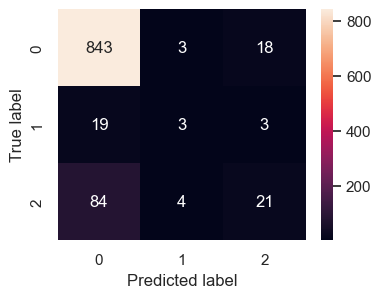

In [348]:
pipeline = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', LinearSVC(class_weight='balanced', random_state=42, max_iter=10000, C=1.44))
])

train_X, train_y = df2['cleaned_text'], df2['label']
test_X, test_y = df2_test['cleaned_text'], df2_test['label']

train_X, train_y = shuffle(train_X, train_y, random_state=42)
pipeline.fit(train_X, train_y)

y_pred = pipeline.predict(test_X)
print(classification_report(y_test, y_pred))
plt.figure(figsize=(4,3))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d')
plt.xlabel("Predicted label")
plt.ylabel("True label")

In [350]:
f1_micro = f1_score(y_test, y_pred, average='micro')
f1_macro = f1_score(y_test, y_pred, average='macro')
print('F1 micro: {:.2f}'.format(100*f1_micro))
print('F1 macro: {:.2f}'.format(100*f1_macro))

F1 micro: 86.87
F1 macro: 46.04


<img src="task62results.png" width="600"/>

Epoch 1/50
282/282 [==============================] - 2s 5ms/step - loss: 0.3490 - accuracy: 0.9123 - val_loss: 0.3099 - val_accuracy: 0.9150
Epoch 2/50
282/282 [==============================] - 1s 4ms/step - loss: 0.2635 - accuracy: 0.9153 - val_loss: 0.3297 - val_accuracy: 0.9140
Epoch 3/50
282/282 [==============================] - 1s 4ms/step - loss: 0.2109 - accuracy: 0.9301 - val_loss: 0.4148 - val_accuracy: 0.9180
Epoch 4/50
282/282 [==============================] - 1s 5ms/step - loss: 0.1769 - accuracy: 0.9396 - val_loss: 0.4181 - val_accuracy: 0.8920
Epoch 5/50
282/282 [==============================] - 1s 5ms/step - loss: 0.1514 - accuracy: 0.9473 - val_loss: 0.4717 - val_accuracy: 0.9020
Epoch 6/50
282/282 [==============================] - 1s 5ms/step - loss: 0.1277 - accuracy: 0.9550 - val_loss: 0.5955 - val_accuracy: 0.8950
Epoch 7/50
282/282 [==============================] - 1s 5ms/step - loss: 0.1126 - accuracy: 0.9604 - val_loss: 0.6989 - val_accuracy: 0.8810
Epoch 

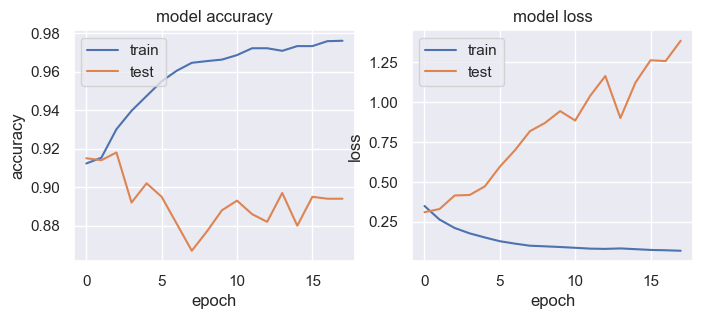

32/32 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

           0       0.87      1.00      0.93       864
           1       0.00      0.00      0.00        25
           2       0.50      0.03      0.05       109

    accuracy                           0.87       998
   macro avg       0.46      0.34      0.33       998
weighted avg       0.81      0.87      0.81       998



/Users/macbook/miniforge3/envs/ml_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/macbook/miniforge3/envs/ml_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/macbook/miniforge3/envs/ml_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

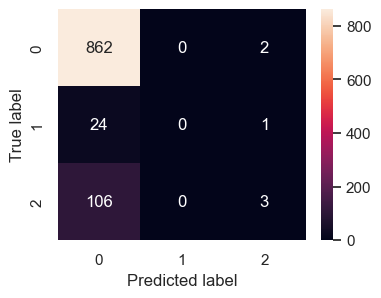

In [124]:
model = Sequential([
    Embedding(max_features, embed_dim, input_length=tweet_tokenized.shape[1]),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(3, activation='softmax')
])

model.compile(loss = 'sparse_categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
# model.summary()
history = model.fit(X_train, y_train, batch_size=32, epochs=50, validation_data=(X_val, y_val), callbacks=es)
model.save('Task62_simple_NN.h5')

plot_history_charts(history)
evaluate_model(model, X_test, y_test)

Epoch 1/50
282/282 [==============================] - 7s 23ms/step - loss: 0.3498 - accuracy: 0.9141 - val_loss: 0.3362 - val_accuracy: 0.9150
Epoch 2/50
282/282 [==============================] - 6s 23ms/step - loss: 0.2708 - accuracy: 0.9166 - val_loss: 0.3227 - val_accuracy: 0.9130
Epoch 3/50
282/282 [==============================] - 6s 23ms/step - loss: 0.2478 - accuracy: 0.9177 - val_loss: 0.3276 - val_accuracy: 0.9030
Epoch 4/50
282/282 [==============================] - 6s 23ms/step - loss: 0.2298 - accuracy: 0.9215 - val_loss: 0.3471 - val_accuracy: 0.9100
Epoch 5/50
282/282 [==============================] - 6s 23ms/step - loss: 0.2148 - accuracy: 0.9259 - val_loss: 0.3732 - val_accuracy: 0.9100
Epoch 6/50
282/282 [==============================] - 6s 23ms/step - loss: 0.1967 - accuracy: 0.9312 - val_loss: 0.3948 - val_accuracy: 0.9120
Epoch 7/50
282/282 [==============================] - 6s 23ms/step - loss: 0.1808 - accuracy: 0.9356 - val_loss: 0.4383 - val_accuracy: 0.9050

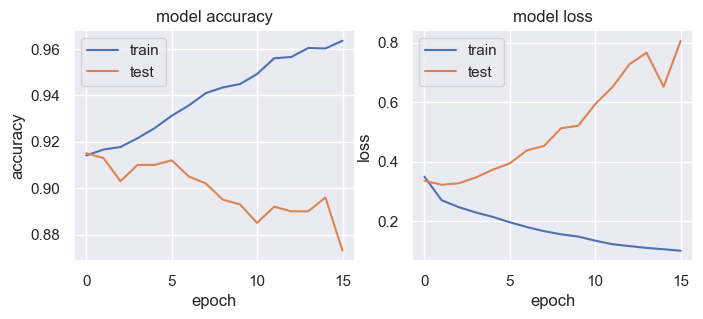

32/32 [==============================] - 0s 4ms/step
              precision    recall  f1-score   support

           0       0.87      1.00      0.93       864
           1       0.00      0.00      0.00        25
           2       0.00      0.00      0.00       109

    accuracy                           0.87       998
   macro avg       0.29      0.33      0.31       998
weighted avg       0.75      0.87      0.80       998



/Users/macbook/miniforge3/envs/ml_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/macbook/miniforge3/envs/ml_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/macbook/miniforge3/envs/ml_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

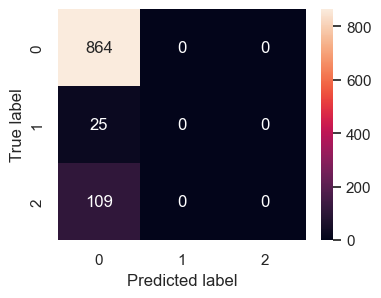

In [125]:
model = Sequential([
    Embedding(input_dim = (len(tokenizer.word_counts) + 1), output_dim = 128, input_length = 25),
    LSTM(128),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(3, activation='softmax')
])

model.compile(loss = 'sparse_categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
history = model.fit(X_train, y_train, batch_size=32, epochs=50, validation_data=(X_val, y_val), callbacks=es)
model.save('Task62_simple_LSTM.h5')

plot_history_charts(history)
evaluate_model(model, X_test, y_test)

Epoch 1/50
282/282 [==============================] - 7s 17ms/step - loss: 0.3590 - accuracy: 0.9150 - val_loss: 0.3191 - val_accuracy: 0.9150
Epoch 2/50
282/282 [==============================] - 4s 16ms/step - loss: 0.2773 - accuracy: 0.9163 - val_loss: 0.3224 - val_accuracy: 0.9140
Epoch 3/50
282/282 [==============================] - 4s 16ms/step - loss: 0.2495 - accuracy: 0.9190 - val_loss: 0.3204 - val_accuracy: 0.9110
Epoch 4/50
282/282 [==============================] - 4s 16ms/step - loss: 0.2293 - accuracy: 0.9237 - val_loss: 0.3354 - val_accuracy: 0.9090
Epoch 5/50
282/282 [==============================] - 4s 16ms/step - loss: 0.2104 - accuracy: 0.9292 - val_loss: 0.3671 - val_accuracy: 0.9140
Epoch 6/50
282/282 [==============================] - 5s 16ms/step - loss: 0.1907 - accuracy: 0.9346 - val_loss: 0.3935 - val_accuracy: 0.9040
Epoch 7/50
282/282 [==============================] - 4s 16ms/step - loss: 0.1735 - accuracy: 0.9412 - val_loss: 0.4196 - val_accuracy: 0.9000

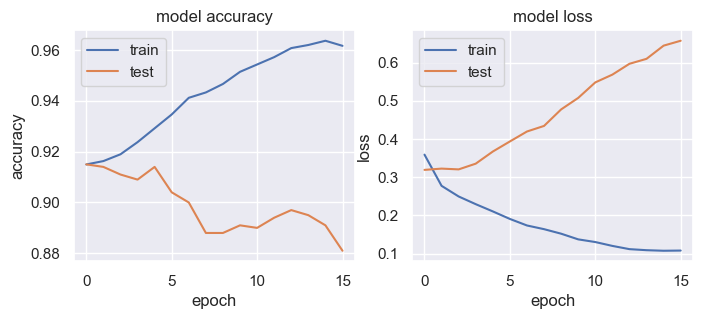

32/32 [==============================] - 1s 4ms/step
              precision    recall  f1-score   support

           0       0.87      1.00      0.93       864
           1       0.00      0.00      0.00        25
           2       0.00      0.00      0.00       109

    accuracy                           0.87       998
   macro avg       0.29      0.33      0.31       998
weighted avg       0.75      0.87      0.80       998



/Users/macbook/miniforge3/envs/ml_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/macbook/miniforge3/envs/ml_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/macbook/miniforge3/envs/ml_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

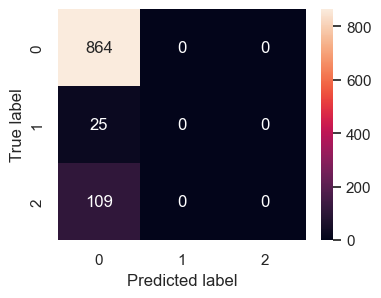

In [126]:
model = Sequential([
    Embedding(max_features, embed_dim, input_length=tweet_tokenized.shape[1]),
    Bidirectional(LSTM(lstm_out, return_sequences=True)),
    Bidirectional(LSTM(lstm_out)),
    Dropout(0.2),
    Dense(3, activation='softmax')
])

model.compile(loss = 'sparse_categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
history = model.fit(X_train, y_train, batch_size=32, epochs=50, validation_data=(X_val, y_val), callbacks=es)
model.save('Task62_bidirectional_LSTM.h5')

plot_history_charts(history)
evaluate_model(model, X_test, y_test)

# Wnioski

- W tym zadaniu nasz najlepszy model uplasowałby się na 4. miejscu w rankingu konkursu.
- Sieci neuronowe poradziły sobie z tym zadaniem znacznie na podobnym poziomie co w poprzednim zadaniu - bardzo przeciętnie.
- Próbowaliśmy poprawić uzyskane wyniki poprzez modyfikowanie różnych hiperparametrów, zmiany architektury sieci, zmiany sposobu preprocesowania tekstu, jednak nie przyniosły one żadnych znaczących popraw.

# Twitter Sentiment Analysis - EN

https://www.kaggle.com/datasets/jp797498e/twitter-entity-sentiment-analysis

In [17]:
nlp = spacy.load('en_core_web_lg')
stop_words = nlp.Defaults.stop_words # 381 stop words

In [18]:
df = pd.read_csv('twitter_training.csv', names=['id', 'category', 'label', 'text'])
df_test = pd.read_csv('twitter_test.csv', names=['id', 'category', 'label', 'text'])

df = df[['text', 'label']]
print('Zbiór treningowy:\nŁącznie: {}\n'.format(len(df)))
print(df['label'].groupby(df['label']).count())
df['label'] = df['label'].map({'Irrelevant':3, 'Positive': 2, 'Neutral': 1, 'Negative': 0})

df_test = df_test[['text', 'label']]
print('\nZbiór testowy:\nŁącznie: {}\n'.format(len(df_test)))
print(df_test['label'].groupby(df_test['label']).count())
df_test['label'] = df_test['label'].map({'Irrelevant':3, 'Positive': 2, 'Neutral': 1, 'Negative': 0})

# df = preprocess_data(df)
# df_test = preprocess_data(df_test)

# df.to_csv('twitter_en_cleaned.csv', index=False)
# df_test.to_csv('twitter_test_en_cleaned.csv', index=False)

# df.head()

Zbiór treningowy:
Łącznie: 74682

label
Irrelevant    12990
Negative      22542
Neutral       18318
Positive      20832
Name: label, dtype: int64

Zbiór testowy:
Łącznie: 1000

label
Irrelevant    172
Negative      266
Neutral       285
Positive      277
Name: label, dtype: int64


In [19]:
df = pd.read_csv('twitter_en_cleaned.csv')
df_test = pd.read_csv('twitter_test_en_cleaned.csv')
df

,text,text_lemmatized_in_tokens,text_lemmatized,cleaned_text,label,sentiment
0,im getting on borderlands and i will murder yo...,"['on', 'Getting', 'on', 'borderlands', 'and', ...",on Getting on borderlands and i will Murder yo...,getting borderlands and will murder you all,2,harmful
1,I am coming to the borders and I will kill you...,"['i', 'am', 'coming', 'to', 'the', 'borders', ...",i am coming to the borders and i will kill you...,am coming the borders and will kill you all,2,harmful
2,im getting on borderlands and i will kill you ...,"['on', 'Getting', 'on', 'borderlands', 'and', ...",on Getting on borderlands and i will kill you ...,getting borderlands and will kill you all,2,harmful
3,im coming on borderlands and i will murder you...,"['on', 'coming', 'on', 'borderlands', 'and', '...",on coming on borderlands and i will Murder you...,coming borderlands and will murder you all,2,harmful
4,im getting on borderlands 2 and i will murder ...,"['on', 'Getting', 'on', 'borderlands', '2', 'a...",on Getting on borderlands 2 and i will Murder ...,getting borderlands and will murder you me all,2,harmful
...,...,...,...,...,...,...
69487,Just realized that the Windows partition of my...,"['Just', 'Realized', 'that', 'the', 'Windows',...",Just Realized that the Windows partition of my...,just realized that the windows paition of mac ...,2,harmful
69488,Just realized that my Mac window partition is ...,"['Just', 'Realized', 'thatć', 'my', 'Mac', 'wi...",Just Realized thatć my Mac window partition is...,just realized thatć mac window paition is year...,2,harmful
69489,Just realized the windows partition of my Mac ...,"['Just', 'realized', 'the', 'windows', 'partit...",Just realized the windows partition of my Mac ...,just realized the windows paition of mac is no...,2,harmful
69490,Just realized between the windows partition of...,"['Just', 'realized', 'between', 'the', 'window...",Just realized between the windows partition of...,just realized between the windows paition of m...,2,harmful


In [20]:
max_features = 2000
embed_dim = 128
lstm_out = 60

df['cleaned_text'] = df['text'].astype('string')
df = df.dropna(subset=['cleaned_text'])

df_test['cleaned_text'] = df_test['text'].astype('string')
df_test = df_test.dropna(subset=['cleaned_text'])

tokenizer = Tokenizer(num_words=max_features, split=' ')
tokenizer.fit_on_texts(df["cleaned_text"].values)
tweet_tokenized = tokenizer.texts_to_sequences(df["cleaned_text"].values)
tweet_tokenized = pad_sequences(tweet_tokenized, maxlen=170)
tweet_tokenized.shape

tweet_tokenized = pd.DataFrame(tweet_tokenized)
y_train = df['label']
X_train, X_val, y_train, y_val = train_test_split(tweet_tokenized, y_train, test_size=0.25, random_state=42, stratify=y_train)

X_test = tokenizer.texts_to_sequences(df_test["cleaned_text"].values)
X_test = pad_sequences(X_test, maxlen=170)
y_test = df_test['label']

              precision    recall  f1-score   support

           0       0.96      0.96      0.96       266
           1       0.97      0.96      0.96       285
           2       0.94      0.96      0.95       276
           3       0.97      0.96      0.96       172

    accuracy                           0.96       999
   macro avg       0.96      0.96      0.96       999
weighted avg       0.96      0.96      0.96       999



Text(17.25, 0.5, 'True label')

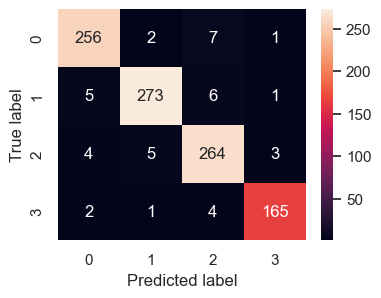

In [23]:
pipeline = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', LinearSVC(class_weight='balanced', random_state=42, max_iter=10000, C=1.44))
])

train_X, train_y = df['cleaned_text'], df['label']
test_X, test_y = df_test['cleaned_text'], df_test['label']

train_X, train_y = shuffle(train_X, train_y, random_state=42)
pipeline.fit(train_X, train_y)

y_pred = pipeline.predict(test_X)
print(classification_report(y_test, y_pred))
plt.figure(figsize=(4,3))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d')
plt.xlabel("Predicted label")
plt.ylabel("True label")

Epoch 1/15
408/408 [==============================] - 15s 37ms/step - loss: 1.0924 - accuracy: 0.5272 - val_loss: 0.8535 - val_accuracy: 0.6701
Epoch 2/15
408/408 [==============================] - 15s 36ms/step - loss: 0.6362 - accuracy: 0.7623 - val_loss: 0.7290 - val_accuracy: 0.7263
Epoch 3/15
408/408 [==============================] - 15s 36ms/step - loss: 0.3701 - accuracy: 0.8653 - val_loss: 0.7657 - val_accuracy: 0.7464
Epoch 4/15
408/408 [==============================] - 15s 36ms/step - loss: 0.2561 - accuracy: 0.9053 - val_loss: 0.8632 - val_accuracy: 0.7498
Epoch 5/15
408/408 [==============================] - 15s 36ms/step - loss: 0.2051 - accuracy: 0.9240 - val_loss: 0.9891 - val_accuracy: 0.7489
Epoch 6/15
408/408 [==============================] - 15s 36ms/step - loss: 0.1698 - accuracy: 0.9367 - val_loss: 1.1071 - val_accuracy: 0.7431
Epoch 7/15
408/408 [==============================] - 15s 36ms/step - loss: 0.1486 - accuracy: 0.9445 - val_loss: 1.2521 - val_accuracy:

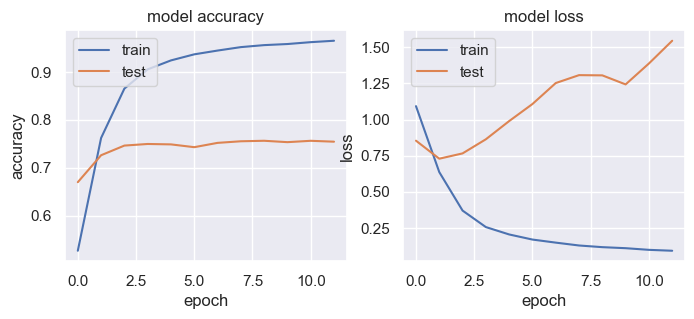

32/32 [==============================] - 0s 6ms/step
              precision    recall  f1-score   support

           0       0.94      0.91      0.93       266
           1       0.88      0.86      0.87       285
           2       0.85      0.91      0.88       276
           3       0.85      0.84      0.84       172

    accuracy                           0.88       999
   macro avg       0.88      0.88      0.88       999
weighted avg       0.89      0.88      0.88       999



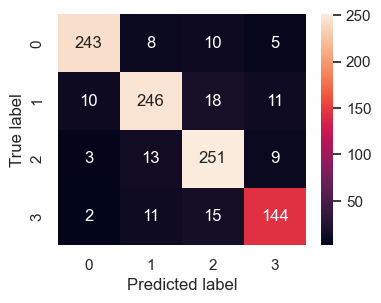

In [236]:
model = Sequential([
    Embedding(max_features, embed_dim, input_length=tweet_tokenized.shape[1]),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.2),
    Dense(256, activation='relu'),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dense(4, activation='softmax')
])

model.compile(loss = 'sparse_categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
history = model.fit(X_train, y_train, batch_size=128, epochs=15, validation_data=(X_val, y_val), callbacks=es)

plot_history_charts(history)
evaluate_model(model, X_test, y_test)

Epoch 1/15
408/408 [==============================] - 129s 309ms/step - loss: 1.0470 - accuracy: 0.5571 - val_loss: 0.9288 - val_accuracy: 0.6251
Epoch 2/15
408/408 [==============================] - 128s 314ms/step - loss: 0.8205 - accuracy: 0.6795 - val_loss: 0.8434 - val_accuracy: 0.6729
Epoch 3/15
408/408 [==============================] - 133s 326ms/step - loss: 0.7289 - accuracy: 0.7216 - val_loss: 0.7968 - val_accuracy: 0.6901
Epoch 4/15
408/408 [==============================] - 134s 330ms/step - loss: 0.6616 - accuracy: 0.7499 - val_loss: 0.7638 - val_accuracy: 0.7074
Epoch 5/15
408/408 [==============================] - 135s 332ms/step - loss: 0.6012 - accuracy: 0.7752 - val_loss: 0.7462 - val_accuracy: 0.7194
Epoch 6/15
408/408 [==============================] - 140s 344ms/step - loss: 0.5406 - accuracy: 0.7996 - val_loss: 0.7198 - val_accuracy: 0.7337
Epoch 7/15
408/408 [==============================] - 141s 346ms/step - loss: 0.4848 - accuracy: 0.8208 - val_loss: 0.7073 -

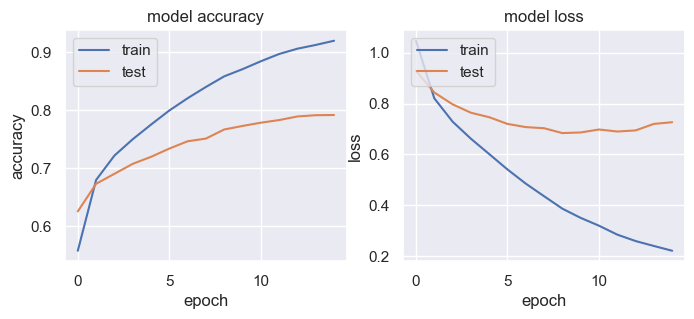

32/32 [==============================] - 2s 35ms/step
              precision    recall  f1-score   support

           0       0.92      0.96      0.94       266
           1       0.93      0.87      0.89       285
           2       0.90      0.88      0.89       276
           3       0.85      0.91      0.88       172

    accuracy                           0.90       999
   macro avg       0.90      0.90      0.90       999
weighted avg       0.90      0.90      0.90       999



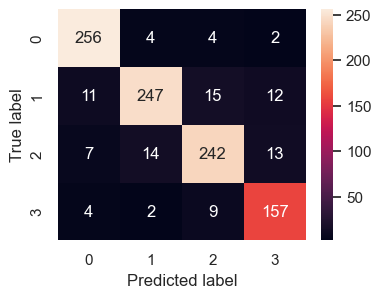

In [237]:
model = Sequential([
    Embedding(max_features, embed_dim, input_length=tweet_tokenized.shape[1]),
    Bidirectional(LSTM(lstm_out, return_sequences=True)),
    Bidirectional(LSTM(lstm_out)),
    Dropout(0.2),
    Dense(4, activation='softmax')
])

model.compile(loss = 'sparse_categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])

history = model.fit(X_train, y_train, batch_size=128, epochs=15, validation_data=(X_val, y_val), callbacks=es)
model.save('TwitterEN_bidirectional_LSTM.h5')

plot_history_charts(history)
evaluate_model(model, X_test, y_test)

# Wnioski

- W tym przypadku również model LinearSVC poradził sobie lepiej od sieci neuronowych, jednak ta różnica była znikoma
- Tym razem sieci neuronowe uzyskały wartość F1 w okolicy 90%, co jest bardzo dobrym wynikiem
- Najlepszy uzyskany wynik, F1 = 96%, pokazuje, że posiadając większy zbiór treningowy i wyższej jakości dane, można uzyskać znacznie lepsze wyniki, o skuteczności wynoszącej często powyżej 90%